In [30]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures

import warnings
from typing import Self
from datetime import datetime
from functools import reduce
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from concurrent.futures import ThreadPoolExecutor, wait, FIRST_COMPLETED

import src.utils.anomalydetectors as m
import src.utils.globals as g
import src.utils.aggregators as agg

from src.utils.noise import NoiseFactory
from src.utils.plotting import plot_rpcurves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class Experiment:
    def __init__(self, name : str = ""):
        self.name = name
        if self.name == "":
            self.name = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        self.results = {
            'df' : pd.DataFrame(),
            'pr' : {},
            'roc' : {},
            'auc-pr' : {},
            'auc-roc' : {},
        }
        self.progress = pd.DataFrame()
        self.anomalies = pd.DataFrame()

    def run(self, df, models : dict[str, m.AnomalyDetector], columns : list[str], spliton=None, verbose=False):
        self.results['df'] = df[['seqid', 'timeindex_bin']].copy()
        #models_results = {model : [] for model in self.models.keys()}
        dfs = [df]

        if spliton:
            dfs = [group for _, group in df.groupby(spliton)]

        if verbose:
            self.progress = pd.DataFrame({model: [f"0/{len(dfs)}"] for model in models.keys()})
            #print(self.progress.to_string(index=False))

        # Let's for every method apply a futures thing...
        def model_fit_scores(name, model, dfs, columns, verbose):
            print(f"model_fit_scores {name} for {len(dfs)} on {columns}")
            r = []
            for df in dfs:
                r += [model.fit_score(df, columns, verbose)]
                self.verbose_progress(name, len(dfs))

            return r
        
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = {
                executor.submit(model_fit_scores, name, model, dfs, columns, False) : name 
                for name, model in models.items()
            }

            while futures:
                # Wait until the first future completes
                done, _ = wait(futures, return_when=FIRST_COMPLETED)

                for future in done:

                    # Retrieve the model name and result
                    name = futures[future]
                    results = pd.concat(future.result())

                    self.results['df'] = self.results['df'].merge(results, on=['seqid', 'timeindex_bin'])

                    # Remove the processed future from the futures dict
                    del futures[future]

        return self

    def calculate_metrics(self, models, aggrfunc, df_anomalous=pd.DataFrame()):     
        if df_anomalous.empty:
            df_anomalous = self.anomalies

        # Calculate series df here
        dfs_series = []
        for (name,_) in models.items():
            dfs_series += [aggrfunc(self.results['df'], [name])]

        df_series = reduce(lambda x, y: pd.merge(x, y, on = 'seqid'), dfs_series)
        df = pd.merge(df_series, df_anomalous, on='seqid')
        

        for (name,_) in models.items():
                self.results['pr'][name]    = precision_recall_curve(df['anomalous'], df[name])
                self.results['auc-pr'][name]  = auc(self.results['pr'][name][1], self.results['pr'][name][0])

                self.results['roc'][name]   = roc_curve(df['anomalous'], df[name])
                self.results['auc-roc'][name]  = auc(self.results['roc'][name][0], self.results['roc'][name][1])

        return self
    
    def set_anomalies(self, df_anomalies):
        self.anomalies = df_anomalies
    
    def verbose_progress(self, method, total):
        # Update
        self.progress.at[0, method] = f"{int(self.progress.at[0, method].split('/')[0]) + 1}/{total}"

        # Clear & Print
        #clear_output(wait=True)
        print(self.progress.to_string(index=False), end='\r')
    
    def plot_rp(self, thresholds=True):
        plot_rpcurves(self.results['pr'])

    def pickle(self):
        with open(self.path(self.name), 'wb') as f:
            pickle.dump(self, f)

    def get(self, key):
        return self.results['key']
    
    @classmethod
    def unpickle(cls, name) -> Self:
        with open(cls.path(name), 'rb') as f:
            return pickle.load(f)
        
    @classmethod
    def path(cls, name):
        return g.experiments_folder_path + f'{name}'
    

In [3]:
def run_experiment(df : pd.DataFrame, models, columns, name, robotsids = []):
    df['anomalous'] = df['anomaly_syn_type'] != ""
    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, columns, spliton="robotid", verbose=True)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(models=models, aggrfunc=agg.aggr_sum)

    experiment.pickle()

    return experiment

def run_gaussian_experiment(df : pd.DataFrame, models, columns, ratio, intensity, robotids = []):
    name = f"gaussian_{ratio}_{intensity}"

    if robotids:
        df = df[df['robotid'].isin(robotids)]
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    df_syn = NoiseFactory.gaussian(df, columns, ratio, intensity)
    return run_experiment(df_syn, models, columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, columns, ratio, intensity, robotids = []):
    name = f"sinus_{ratio}_{intensity}"

    if robotids:
        df = df[df['robotid'].isin(robotids)]
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    df_syn = NoiseFactory.sinusoidal(df, columns, ratio, intensity)
    return run_experiment(df_syn, models, columns, name)

def run_point_experiment(df : pd.DataFrame, models, columns, ratio, intensity, robotids = []):
    name = f"point_{ratio}_{intensity}"

    if robotids:
        df = df[df['robotid'].isin(robotids)]
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    df_syn = NoiseFactory.point(df, columns, ratio, intensity)
    return run_experiment(df_syn, models, columns, name)

In [4]:
df_in = pd.read_parquet(g.path_tracks)
ids = ['6640-102140-1']
models = {"z" : m.ZScore(), "mz" : m.MZScore(), "lof" : m.LOF(), 'if' : m.IF()}


# GAUSSIAN

In [27]:
exps_gaussian = {}
for intensity in [0.05, 0.1, 0.2,  0.3, 0.4, 0.5]:
    print(f"Running Experiment gaussian {intensity}")
    exp = run_gaussian_experiment(df_in, models, ['torqueactual'], ratio=0.1, intensity=intensity, robotids=ids)
    exps_gaussian[exp.name] = exp

  z  mz lof  if
1/1 1/1 1/1 1/1


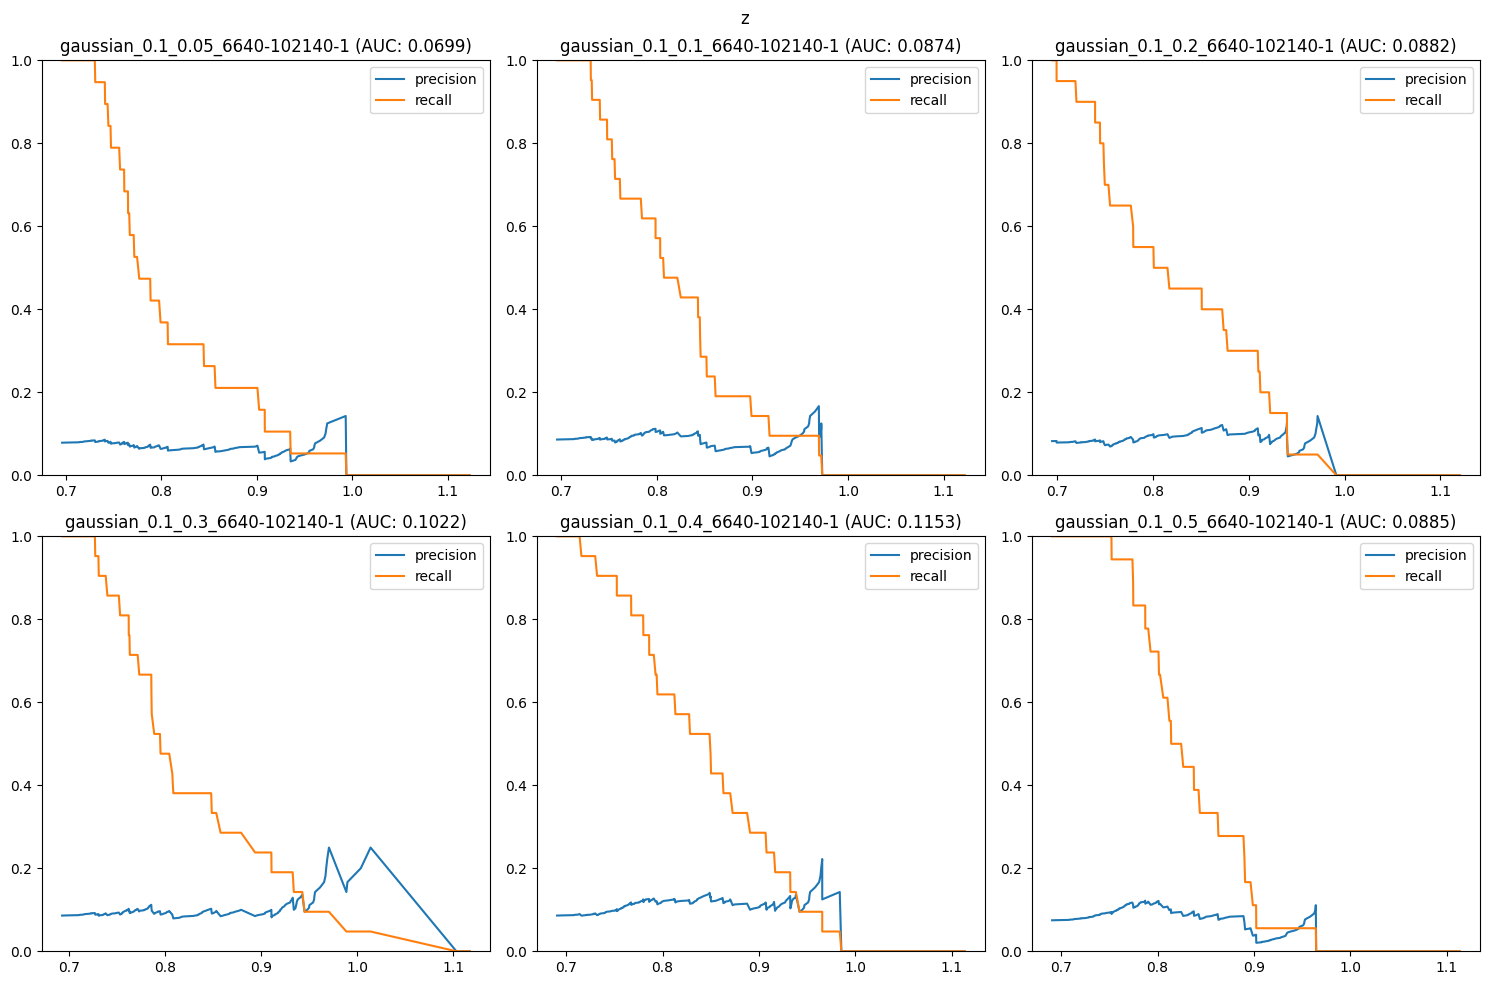

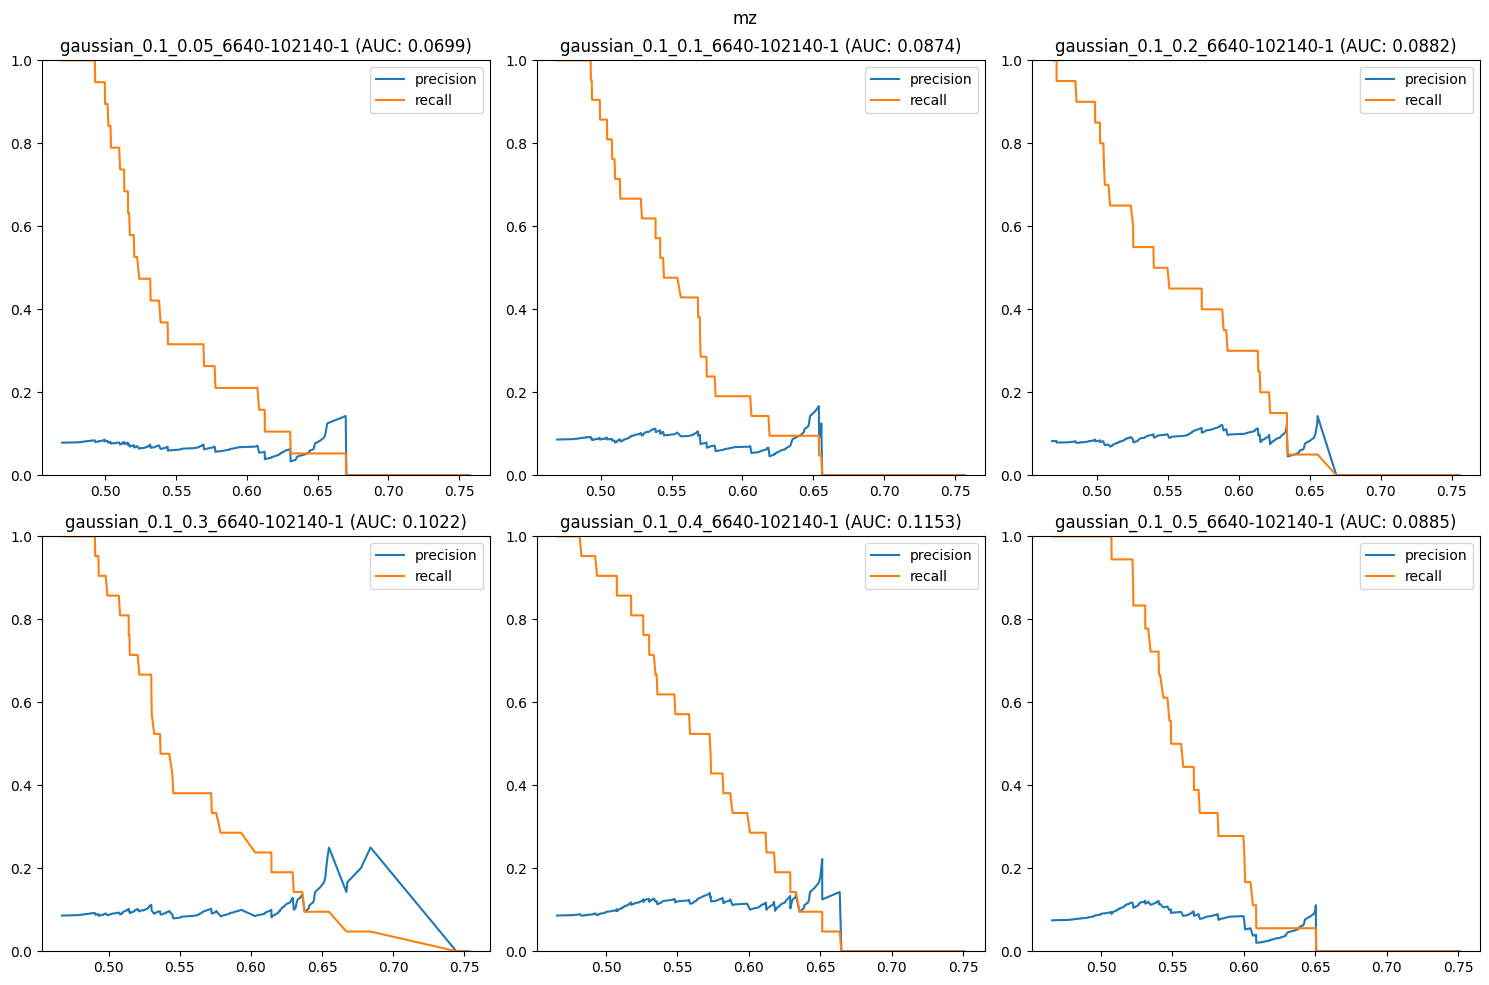

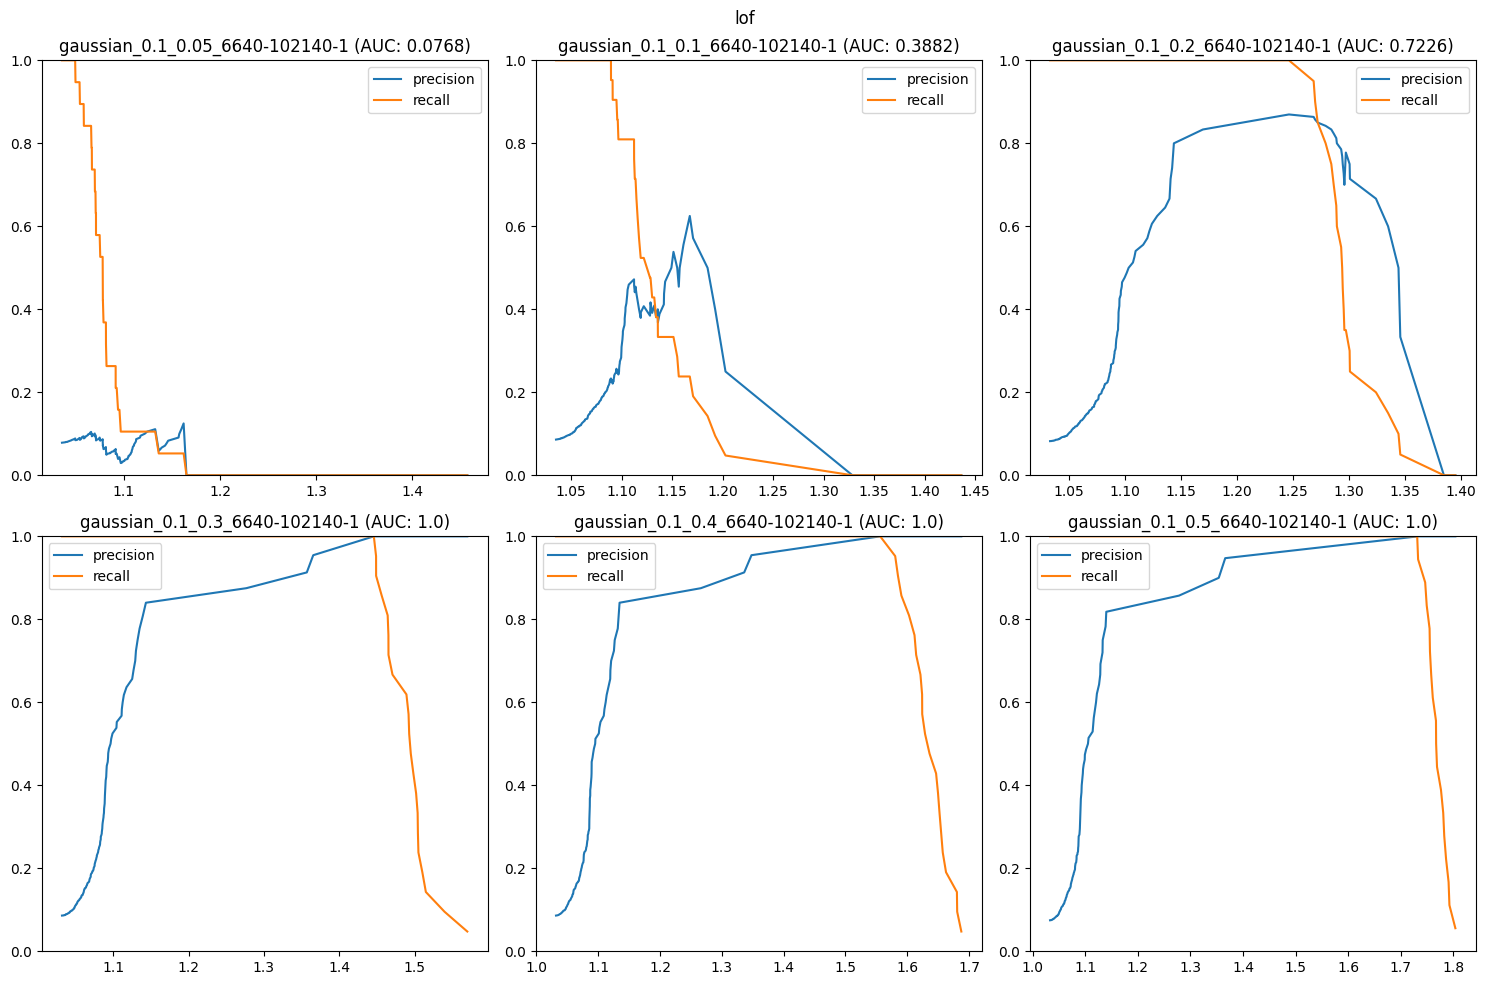

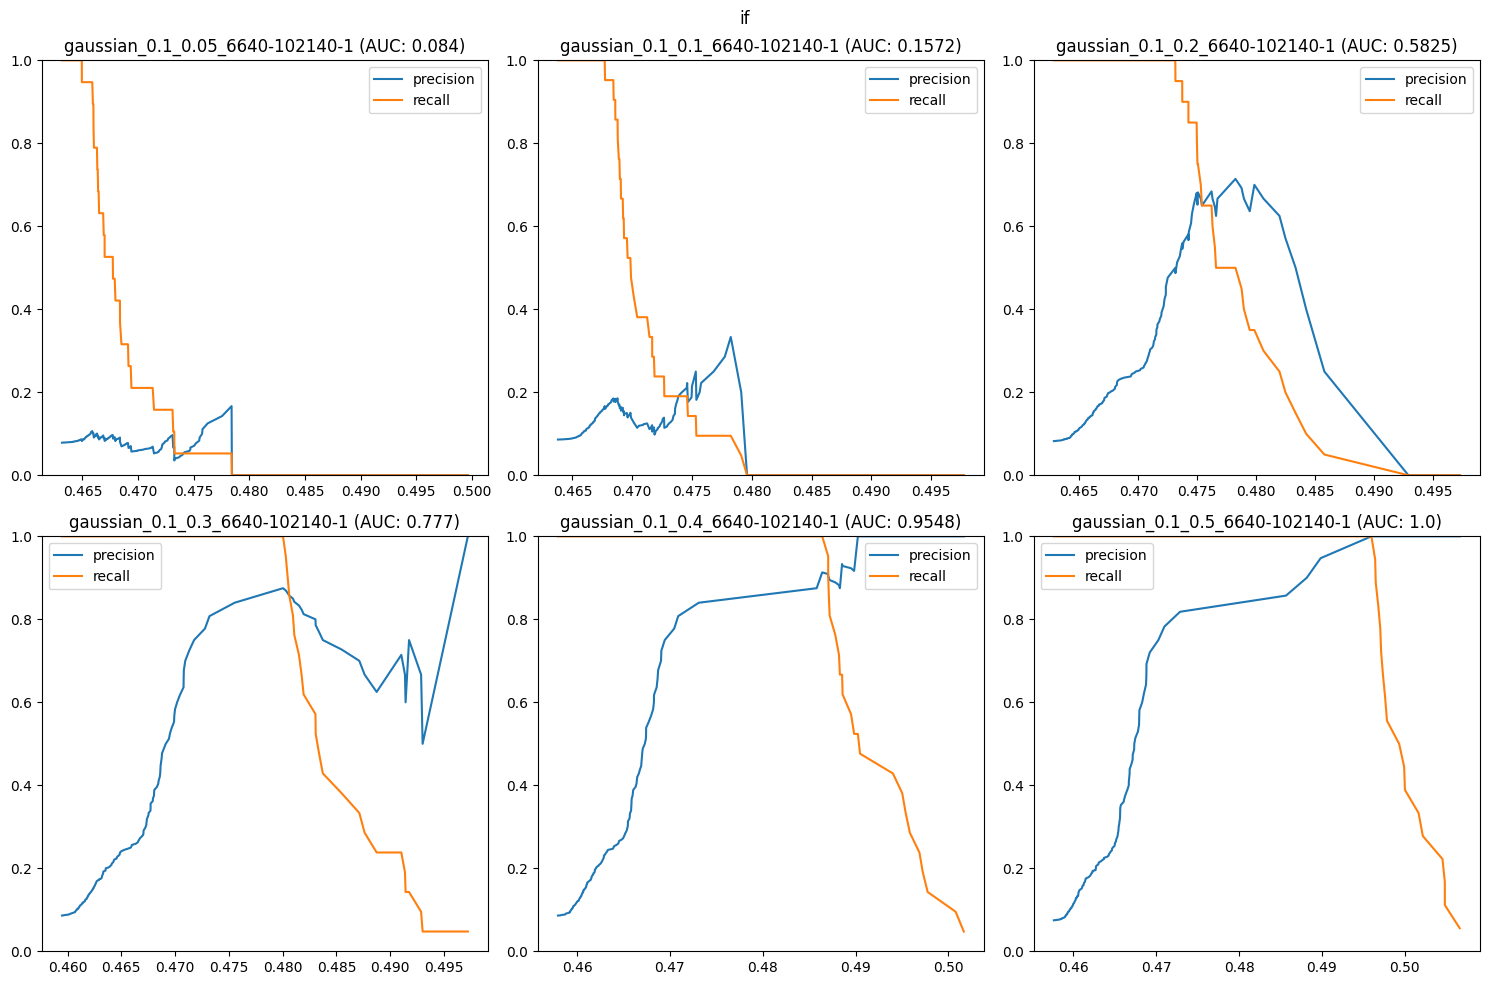

In [33]:
rp_curves = {}
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=3, title=mname, auc=True, f1=False)
        

In [ ]:
aucs
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]

# SINUSOIDAL

In [39]:
exps_sinusoidal = {}
for intensity in [0.25, 0.5, 0.75, 1, 1.5, 2]:
    print(f"Running Experiment sinusoidal {intensity}")
    exp = run_sinusoidal_experiment(df_in, models, ['torqueactual'], ratio=0.1, intensity=intensity, robotids=ids)
    exps_sinusoidal[exp.name] = exp

  z  mz lof  if
1/1 1/1 1/1 1/1


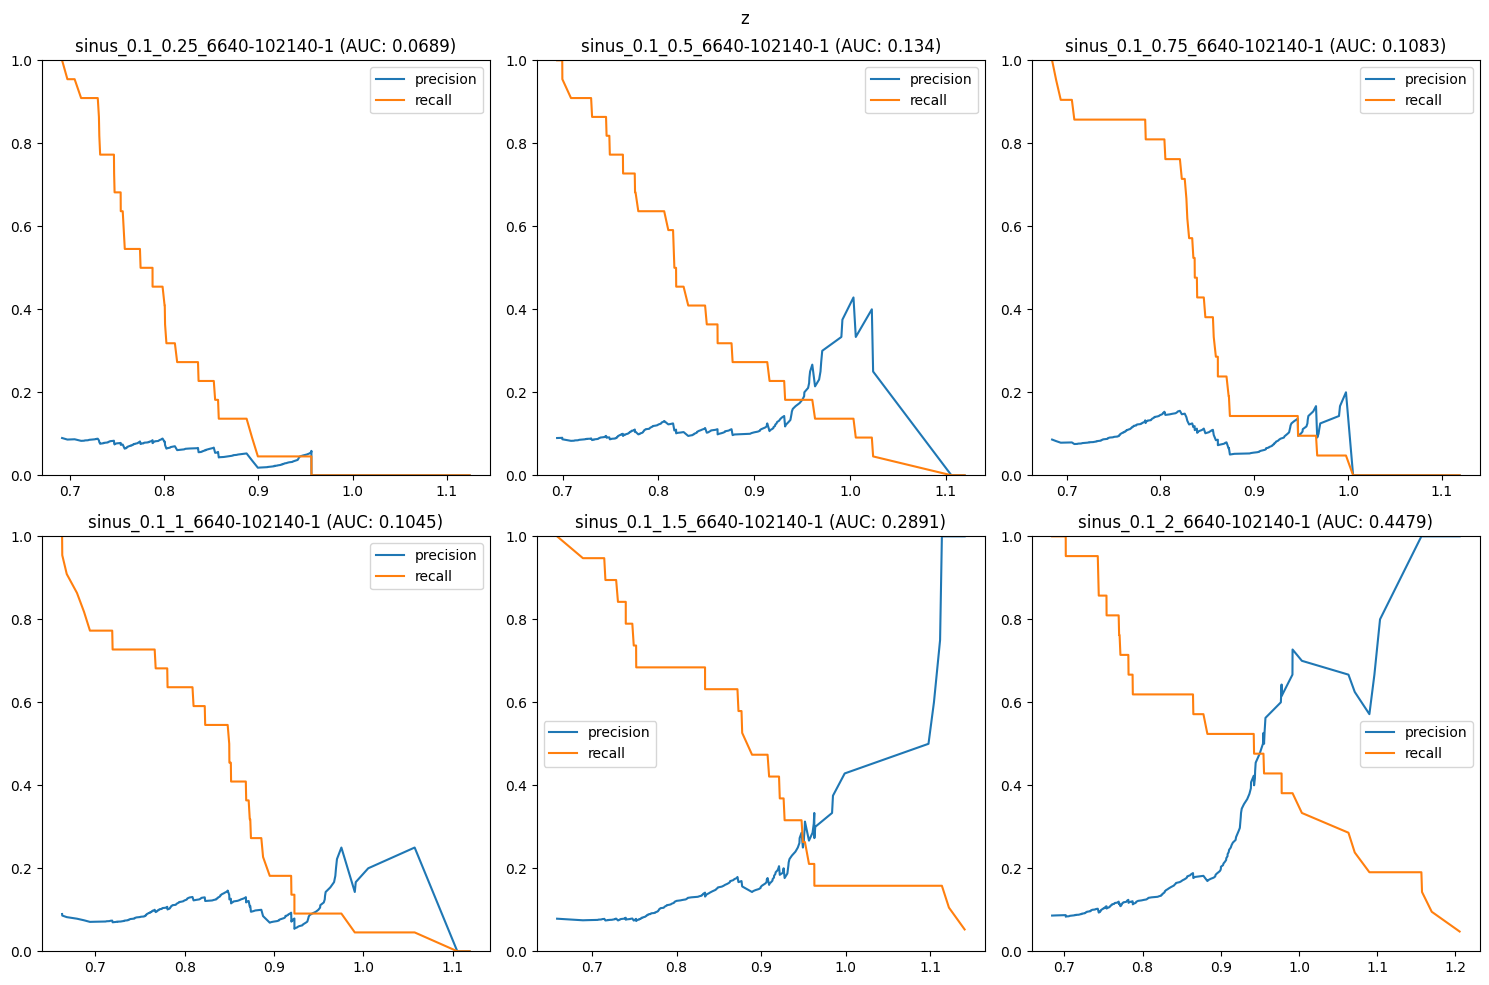

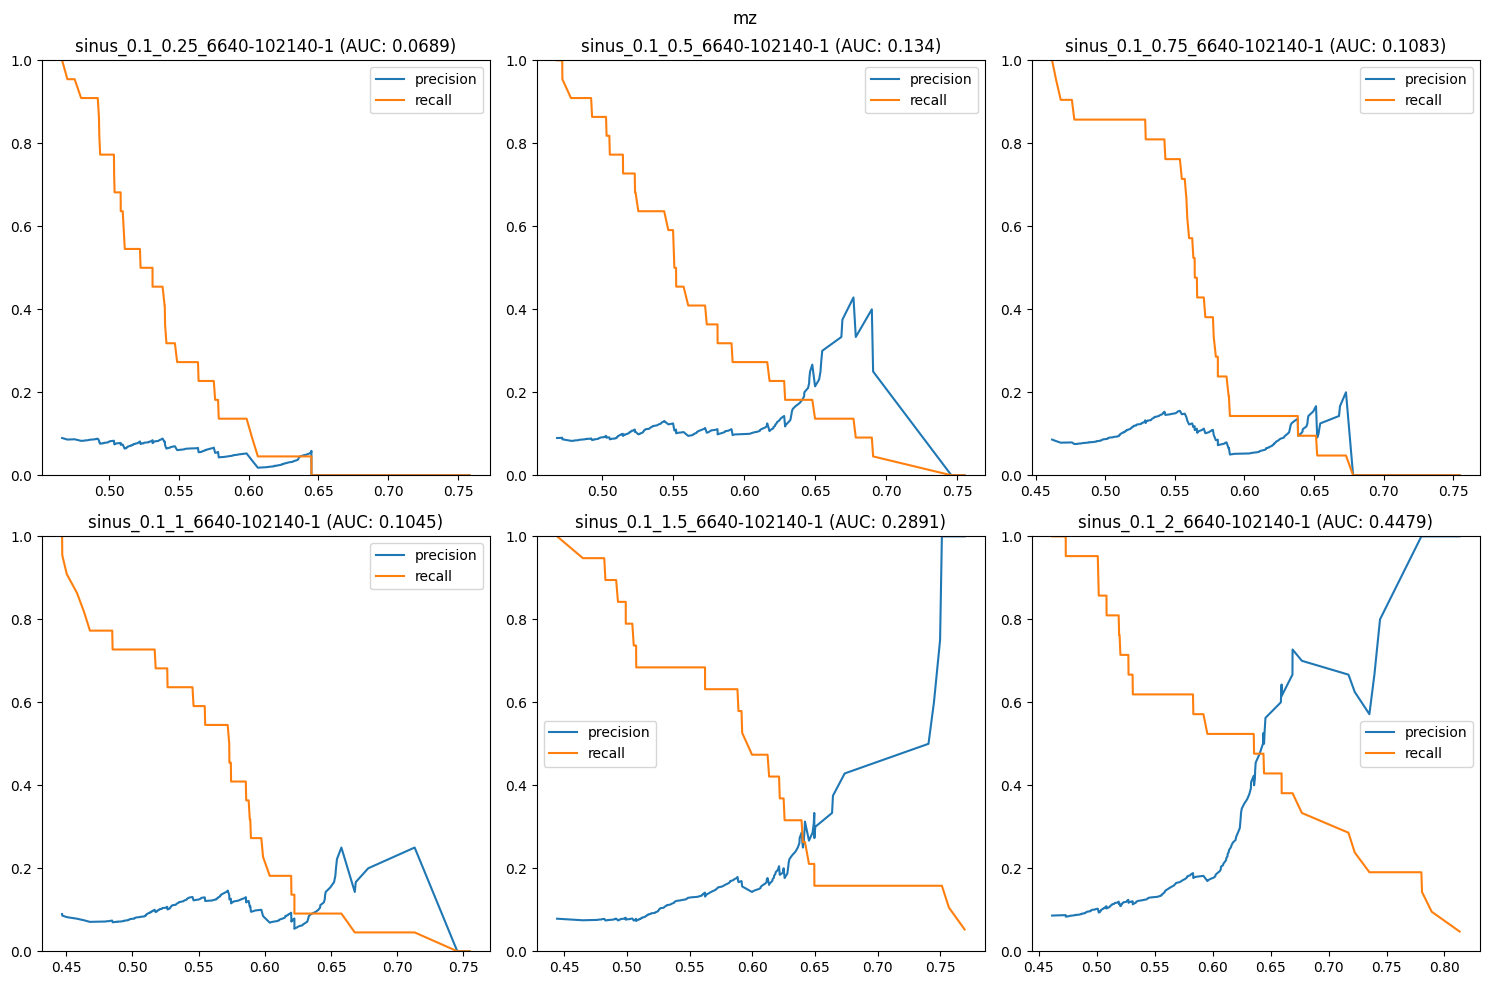

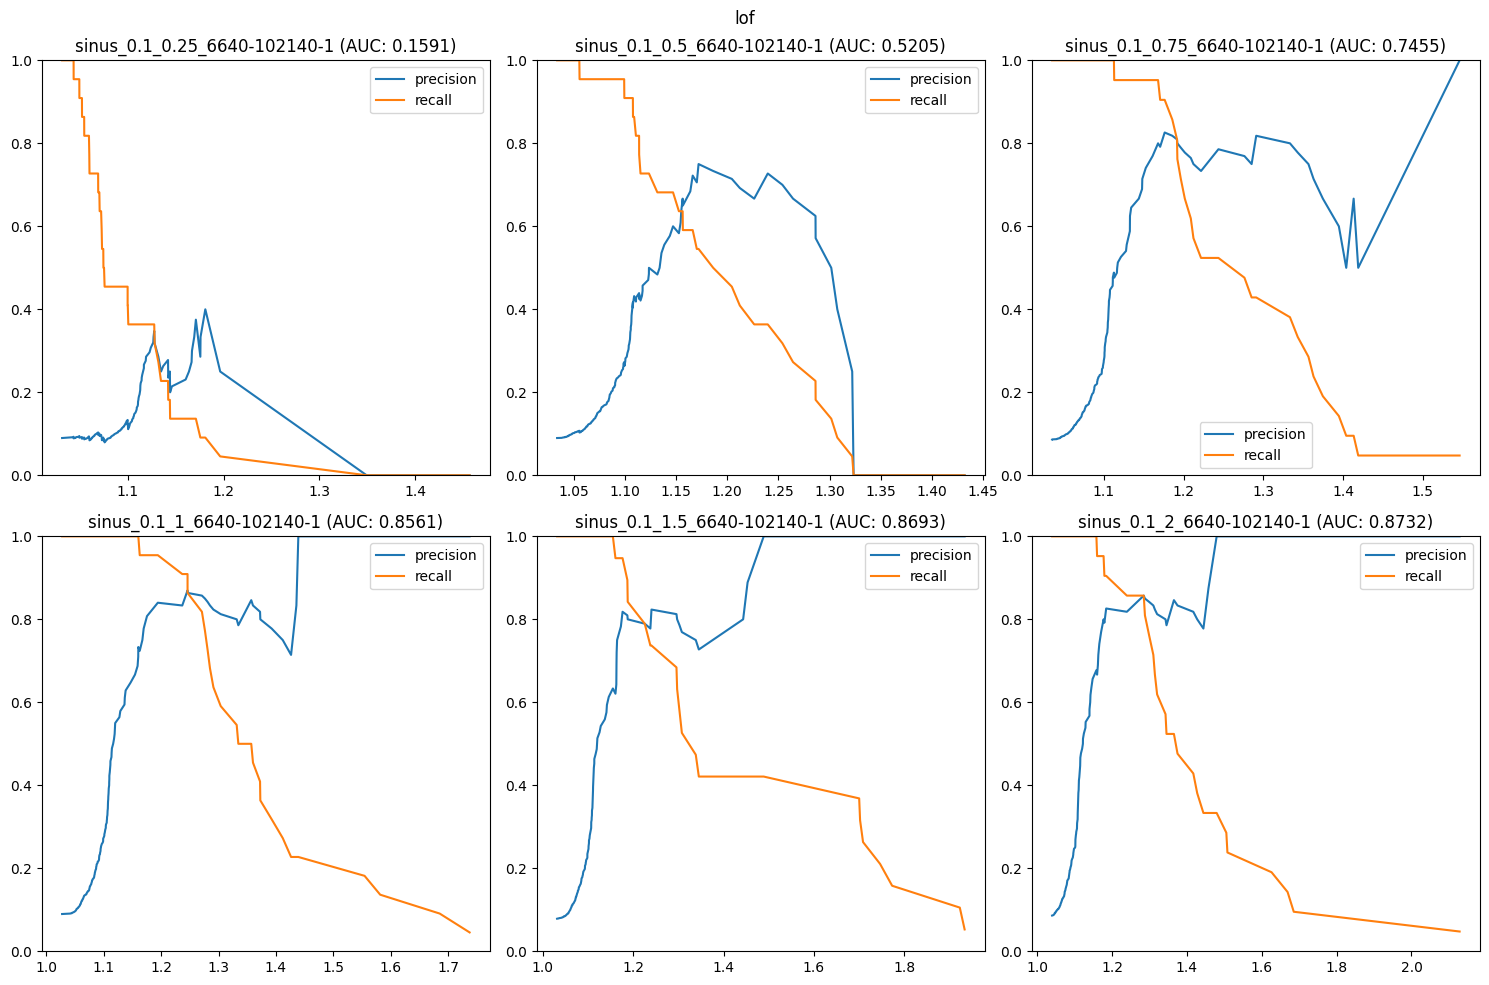

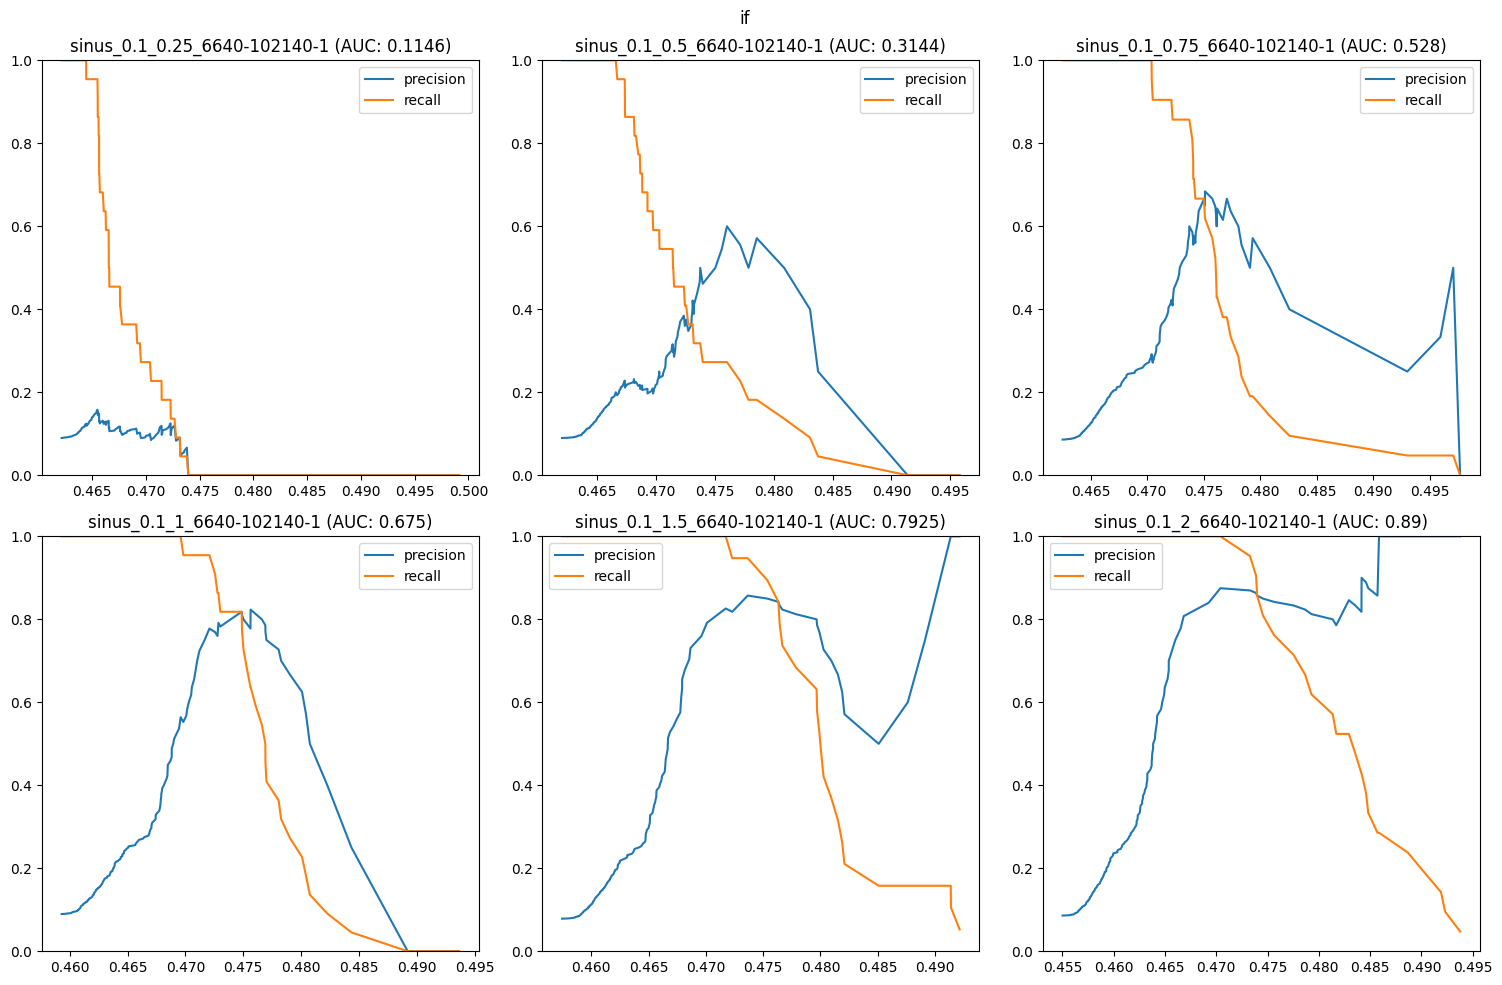

In [40]:
rp_curves = {}
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=3, title=mname, auc=True, f1=False)

# POINT

In [43]:
exps_point = {}
for intensity in [1, 5, 10, 100]:
    print(f"Running Experiment point {intensity}")
    exp = run_point_experiment(df_in, models, ['torqueactual'], ratio=0.1, intensity=intensity, robotids=ids)
    exps_point[exp.name] = exp

  z  mz lof  if
1/1 1/1 1/1 1/1


c:\Users\P70080564\OneDrive - Maastricht University\Desktop\project\bodyshop-project\src\utils\plotting.py:41: RuntimeWarning: invalid value encountered in divide
  else:


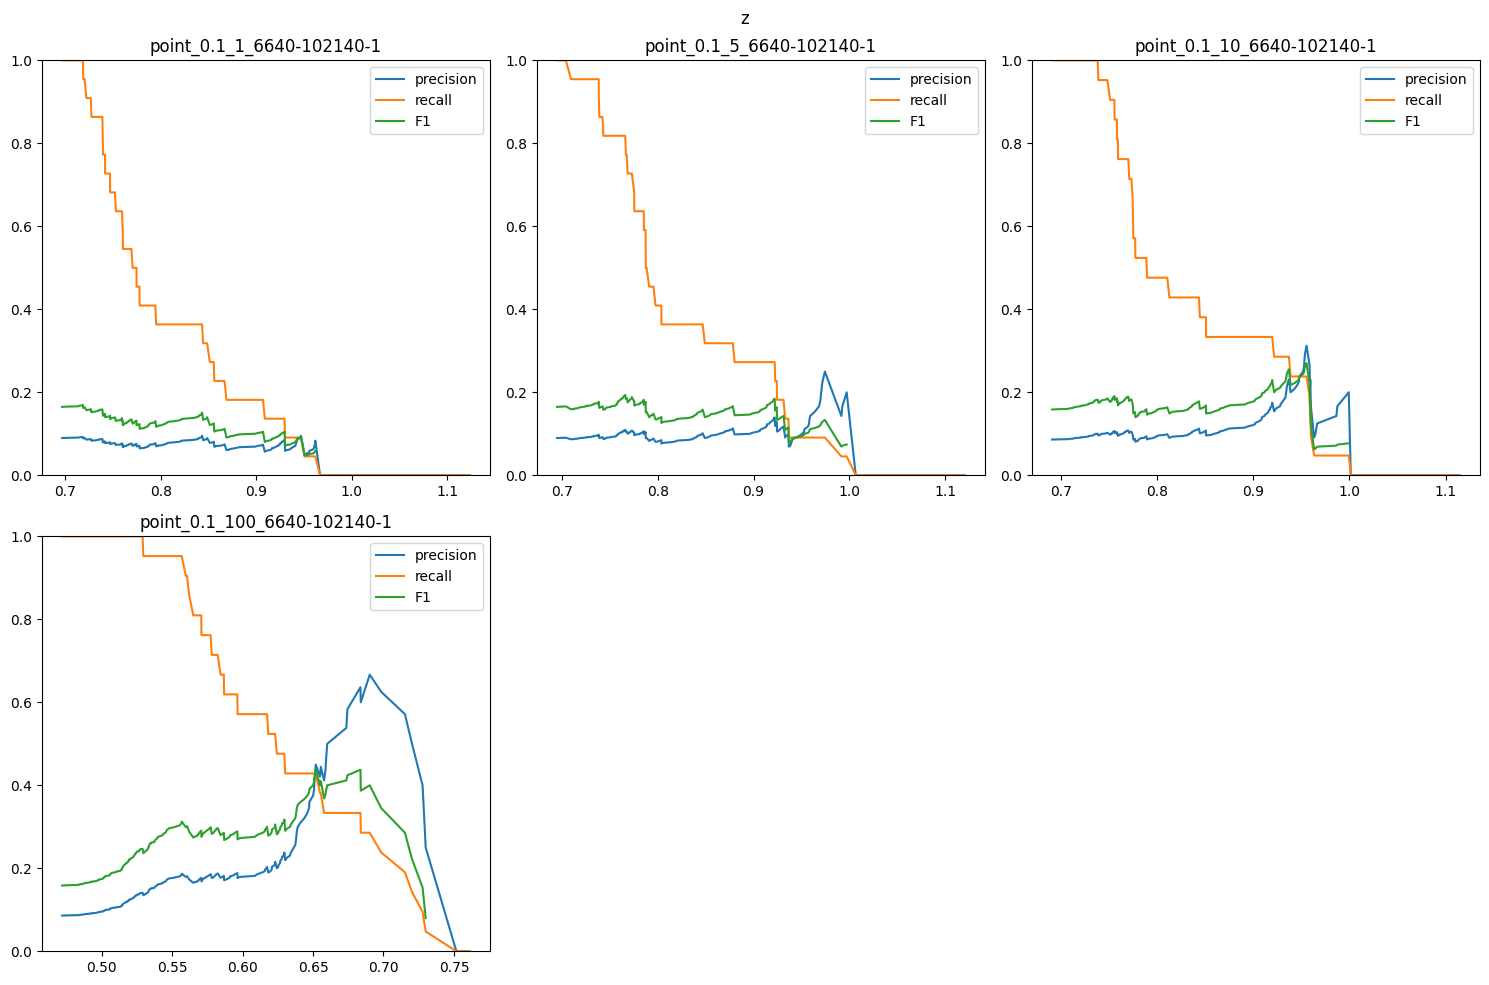

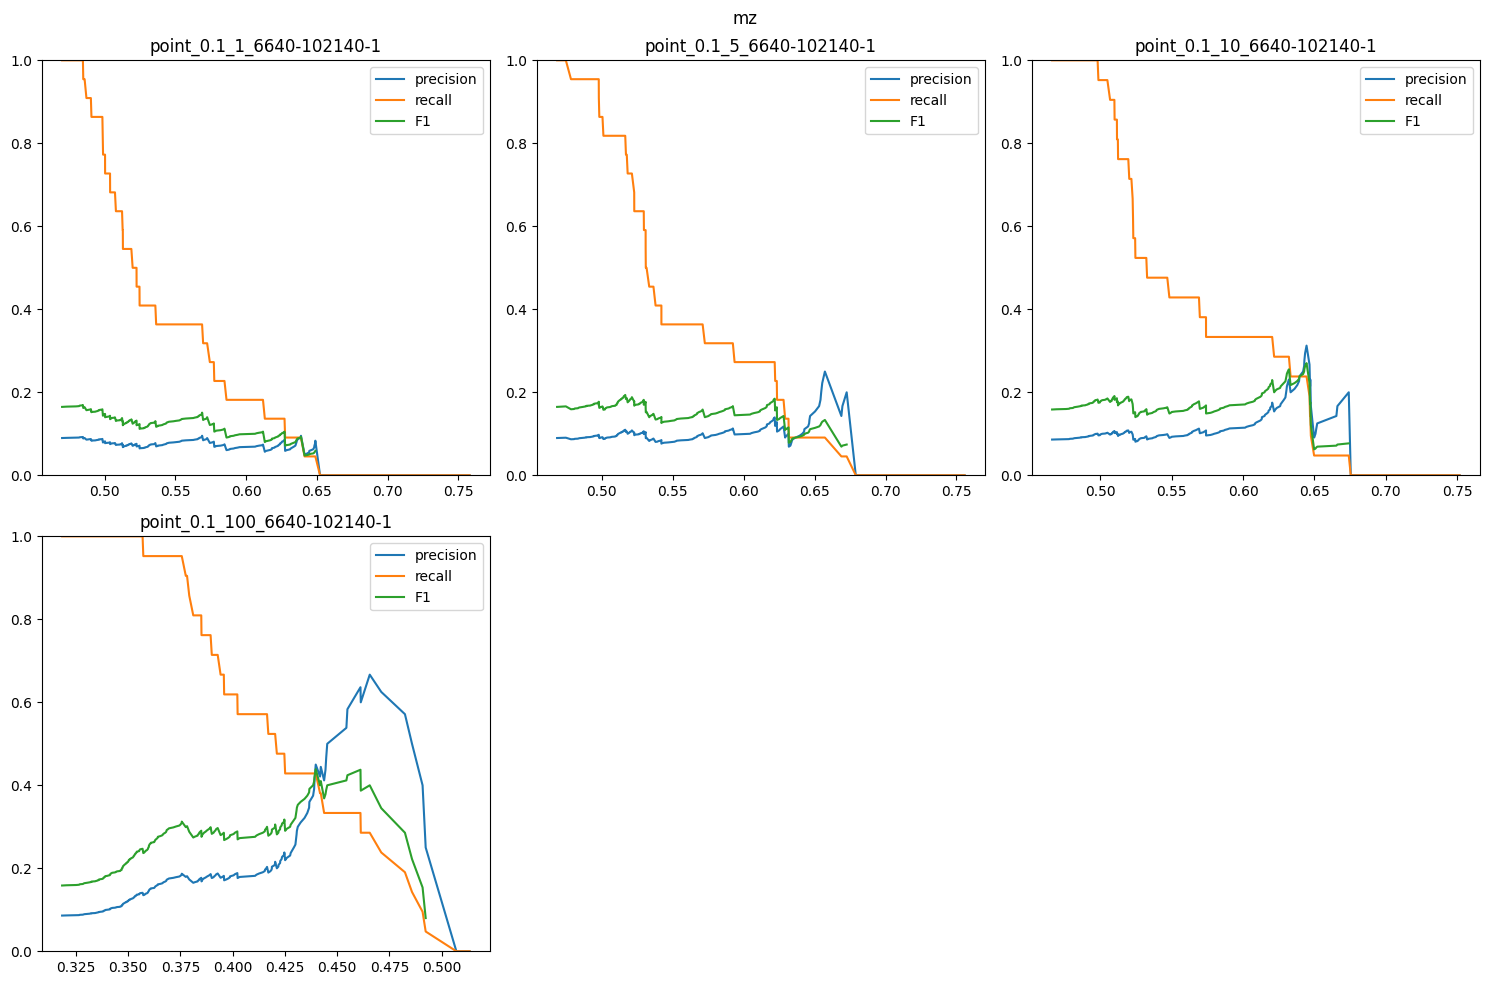

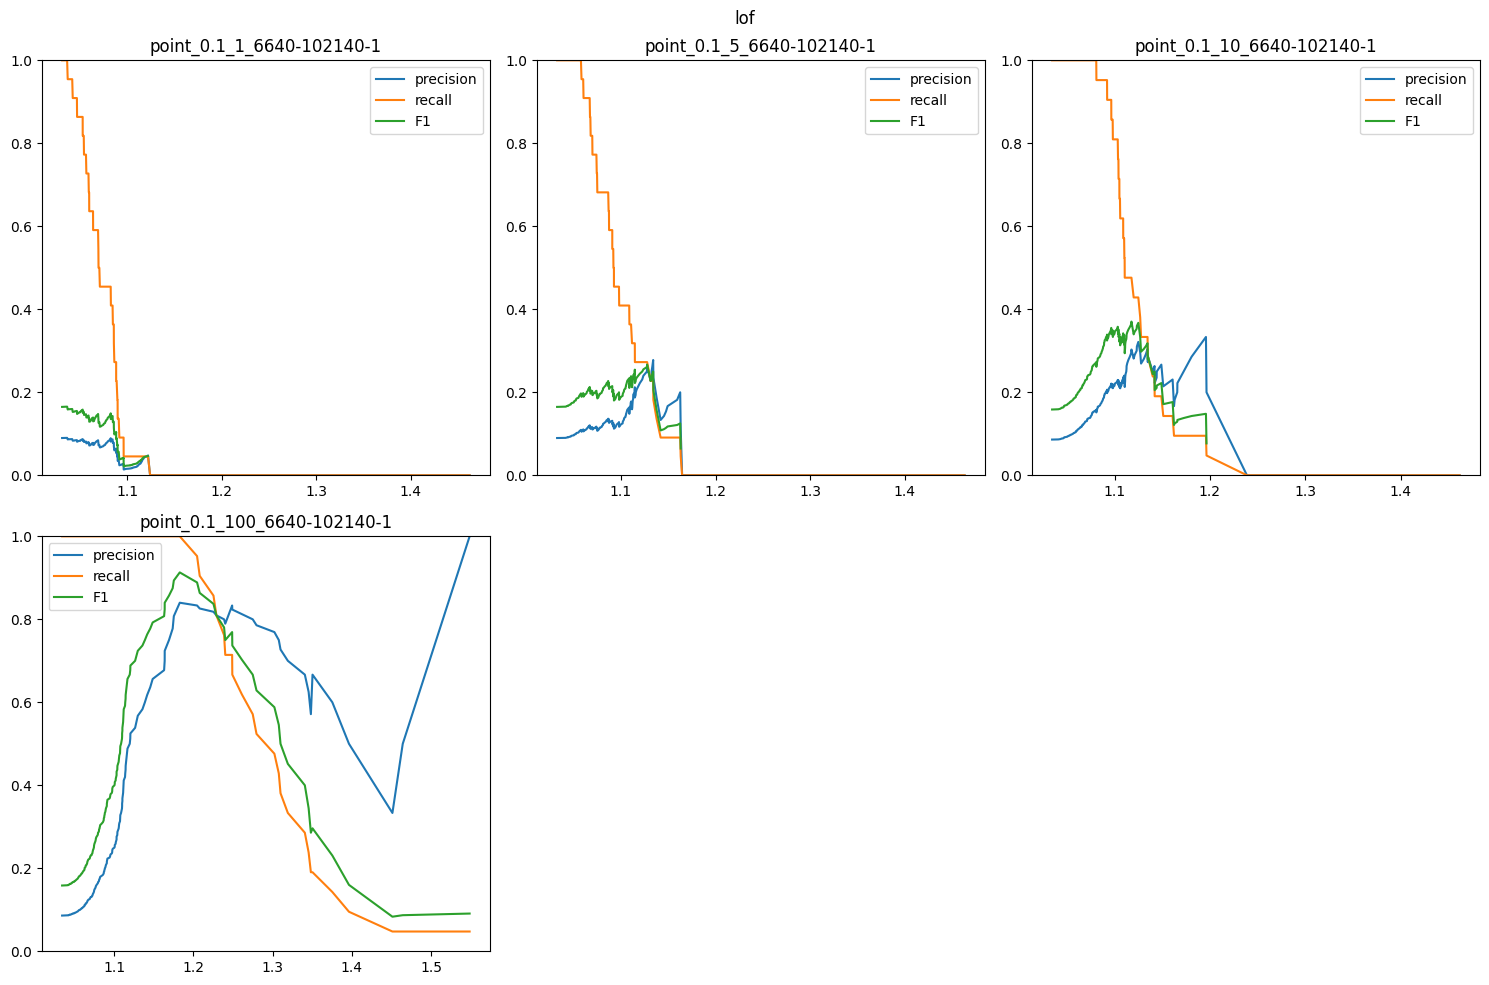

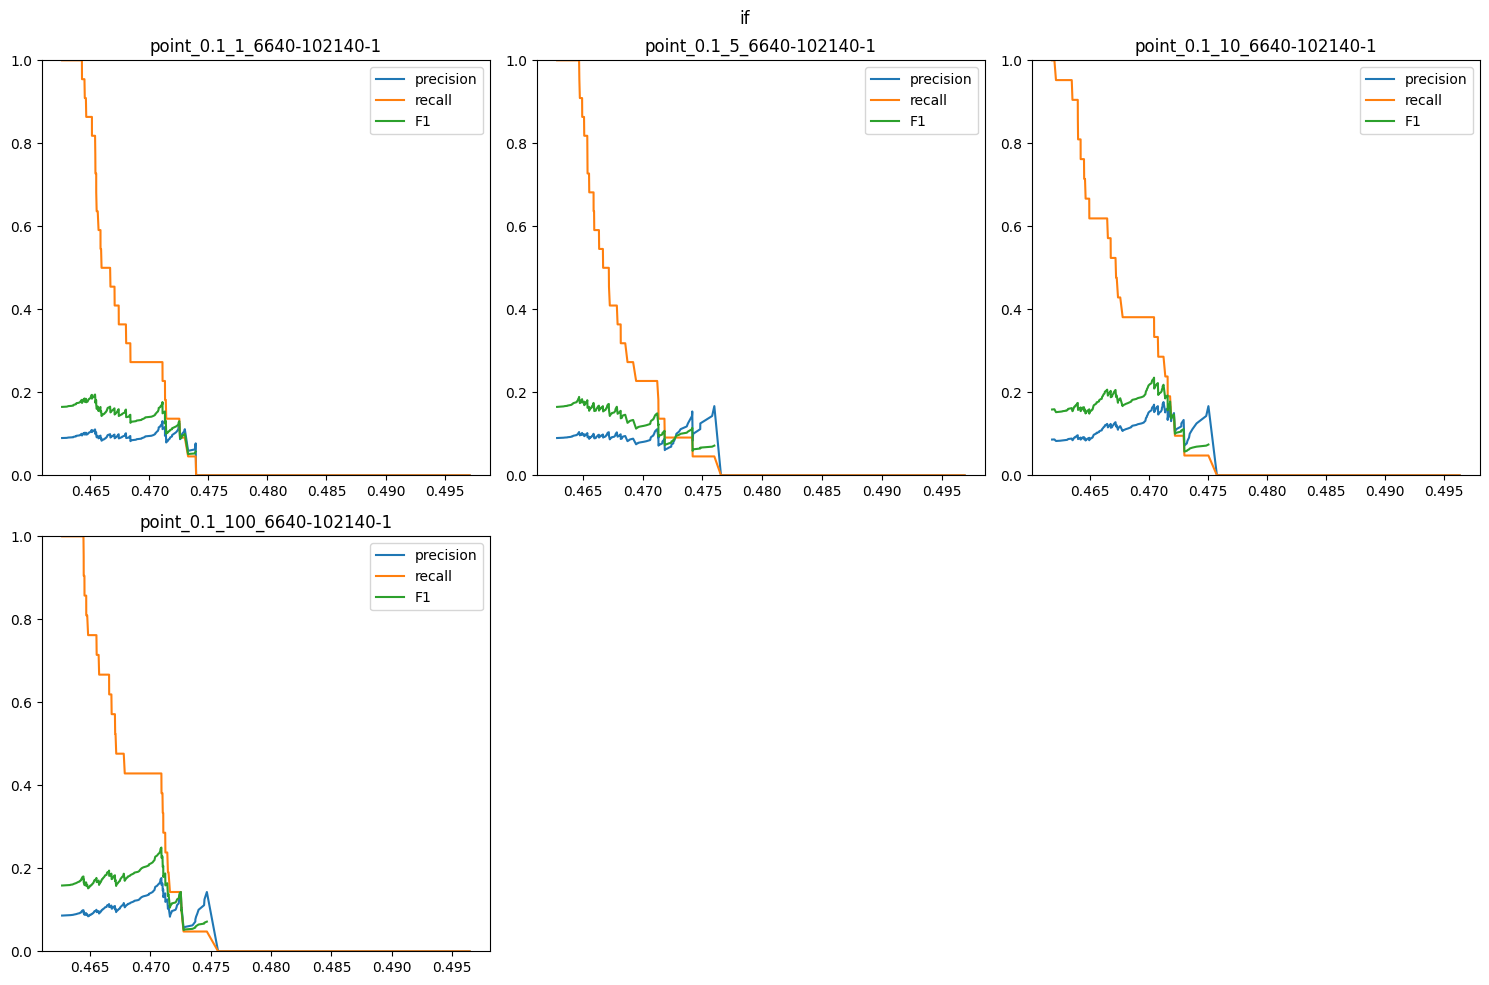

In [44]:
rp_curves = {}
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_point.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    plot_rpcurves(rp_curves[mname], colnums=3, title=mname)   

In [ ]:
# for intensity in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]:
#     print(f"Running Experiment gaussian {intensity}")
#     run_gaussian_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
# for intensity in [0.25, 0.5, 0.75, 1, 1.25, 1.5]:
#     print(f"Running Experiment point {intensity}")
#     run_point_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
#     print(f"Running Experiment sinusoidal {intensity}")
#     run_sinusoidal_experiment(df_in, models, ['torqueactual'], 0.1, intensity)

In [ ]:
folder_path = g.experiments_folder_path

files_to_unpickle = [
    file for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file)) and file.endswith("6640-102140-1")
]

files_to_unpickle


In [59]:
unpickled_data = {}
for file_name in files_to_unpickle:
    unpickled_data[file_name] = Experiment.unpickle(file_name)    
    
for (name, exp) in unpickled_data.items():
    print(f"{name} - {exp.results['auc-pr']}")